# Homework solution 

### Student: Megi Dervishi

In [2]:
# execute this part to modify the css style
from IPython.core.display import HTML
def css_styling():
    styles = open("./style.css").read()
    return HTML(styles)
css_styling()

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from imutils import paths
import random
import time
import scipy.io as sio
import sklearn
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.optimize import curve_fit

### Load the dataset

In [4]:
def load_data():
    #load from train -> from folder A have label 1 else have label 0
    # load from test -> same thing
    # shuffle
    print("Loading images...")
    df_train = pd.DataFrame()
    train_data, train_labels = [], []
    test_data, test_labels = [], []
    imgpath = sorted(list(paths.list_images("./data")))
    random.seed(time.time())
    random.shuffle(imgpath)
    
    for ipath in imgpath:
        #print(ipath)
        image = cv2.imread(ipath,0)
        image = image.astype('float32') / 255
        tmp1, tmp2 = ipath.split(os.path.sep)[-3] , ipath.split(os.path.sep)[-2]
        #perhaps normalize the set X
        if tmp1 == "train": 
            train_data.append(image.flatten())
            if tmp2 == "A" and tmp1 == "train": 
                train_labels.append(1)
            else:
                train_labels.append(-1)
        else: 
            test_data.append(image.flatten())
            if tmp2 == "A": 
                test_labels.append(1)
            else: 
                test_labels.append(-1)
        #print(test_data)
        #input()
                
    train_data, test_data = np.array(train_data), np.array(test_data)
    train_labels, test_labels = np.array(train_labels), np.array(test_labels)
    #df_train['Labels'] = [list(_) for _ in keras.utils.to_categorical(train_labels, 2)]
    print("Loading dataset done.")
    return train_data, test_data, train_labels, test_labels

In [5]:
train_data, test_data, train_labels, test_labels = load_data()

Loading images...
Loading dataset done.


### Define the Dataset

The images are $28$ by $28$ pixels that range from 0 to 255 but I have normalized them to range from 0 to 1. Hence we have that $\mathcal{X} \in [0,1]^{784}$ and $\mathcal{Y} \in \{1,-1\}$

In [6]:
print("Total training images: ", train_data.shape)
print("Total testing images: ", test_data.shape)
print("Number of 'A' from the training data: {} images".format(list(train_labels).count(1)))
print("Number of 'A' from the test data: {} images ".format(list(test_labels).count(1)))
print("Shape of the images: ", train_data[0].shape[0])

Total training images:  (6000, 784)
Total testing images:  (750, 784)
Number of 'A' from the training data: 2000 images
Number of 'A' from the test data: 250 images 
Shape of the images:  784


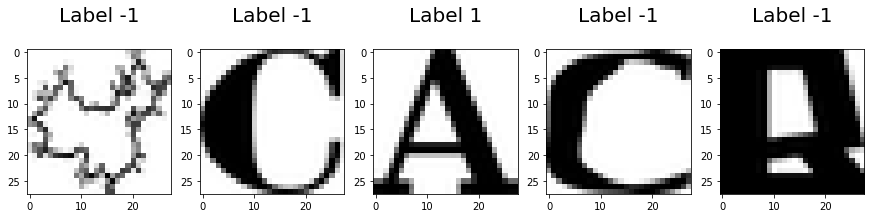

In [7]:
#examples from the dataset
plt.figure(figsize=(15,10))
for index, (image, label) in enumerate(zip(train_data[0:5], train_labels[0:5])):
 plt.subplot(1, 5, index + 1)
 plt.imshow(image.reshape(28,28), cmap='binary')
 plt.title('Label %i\n' % label, fontsize = 20)

### Gradient Descent and Stochastic Gradient Descent

<div markdown=1 class="Def"> 
Let $\theta$ be the estimator and $X_i$ the image $i$ of the dataset $X$ and $Y_i$ the label corresponding to it. 
- Least square loss
\begin{align*}\hat{R_n}(\theta) = \frac{1}{n}\sum_{i=1}^n (\theta^TX_i - Y_i)^2 \quad \quad \quad
\nabla_{\theta} \hat{R_n}&= \frac{2}{n}\sum_{i=1}^n X_i(\theta^TX_i - Y_i)\\
&= \frac{2}{n}\sum_{i=1}^n X_i\theta^TX_i - X_iY_i
\end{align*}

- Logistic square loss
\begin{align*} \hat{R_n}(\theta) = \frac{1}{n}\sum_{i=1}^n \log(1 + e^{−Y_i\theta^T X_i}) \quad \quad
\nabla_{\theta} \hat{R_n} &= \frac{1}{n}\sum_{i=1}^n -X_i Y_i \frac{e^{-Y_i\theta^TX_i}}{1+e^{−Y_i\theta^T X_i}}
\end{align*}

In [8]:
def loss(ID,x,y,theta):
    if ID: 
        #square loss = 1
        return 1/len(y) * np.sum((np.dot(x,theta) - y)**2)
    else:
        #logistic loss = 0
        s = -np.dot(x, theta) * y
        return 1/len(y) * np.sum(np.log(1 + np.exp(s)))

def grad(ID, x,y,theta):
    if ID:
        # grad square loss = 1
        return 1/len(y)*2* np.dot(x.T,(np.dot(x,theta) - y))
    else :
        # grad logistic loss = 0
        s = -np.dot(x, theta) * y
        frac = np.exp(s)/(1+ np.exp(s))
        return -1/len(y) * np.dot(x.T, y * frac)
                
def error(data,theta, labels):
    #computes the error and accuracy by rounding the results
    E = np.dot(data, theta)
    acc = 0
    for x,y in zip(E, labels):
        if x > 0 and y == 1: acc += 1 
        elif x < 0 and y== -1: acc += 1
    return acc/len(labels), 1 - acc/len(labels)

In [9]:
def gradient_descent(train_x, train_y, test_x, test_y, itheta, loss_ID, eta, max_iteration, case = 1):
    train_errors , test_errors = [], []
    theta = itheta
    theta_avg = itheta # Exercise 3.c
    for _ in range(max_iteration):
        if case:
            train_errors.append(loss(loss_ID,train_x, train_y, theta))
            test_errors.append(loss(loss_ID, test_x, test_y, theta))
        grd = grad(loss_ID, train_x, train_y, theta)
        theta = theta - eta*grd
        theta_avg += theta
    return theta, theta_avg/max_iteration, train_errors, test_errors

def stochastic_gradient_descent(train_x, train_y, test_x, test_y, itheta, loss_ID, eta, max_iteration, case=1):
    train_errors , test_errors = [], []
    theta = itheta
    theta_avg = itheta # Exercise 3.c
    for _ in range(max_iteration):
        i = np.random.randint(0, len(train_y), size=1)
        if case:
            train_errors.append(loss(loss_ID,train_x, train_y, theta))
            test_errors.append(loss(loss_ID, test_x, test_y, theta))
        grd = grad(loss_ID, train_x[i], train_y[i], theta)
        theta = theta - eta*grd
        theta_avg += theta
    return theta, theta_avg/max_iteration, train_errors, test_errors
        

### Results

In [14]:
#GD square loss
itheta = np.ones(784)*1e-4
print("Loading GD square loss...")
stheta, stheta_avg, strain_errors, stest_errors = gradient_descent(train_data, train_labels, test_data, test_labels, 
                                                               itheta, 1, eta = 0.001, max_iteration = 500)
print("Done. Loading SGD square loss...")
#SGD square loss
itheta = np.ones(784)*1e-4
st, st_avg, strain_e, stest_e = stochastic_gradient_descent(train_data, train_labels, test_data, test_labels, 
                                                               itheta, 1, eta = 0.0001, max_iteration = 5000)
print("Done. Loading GD logistic loss...")
#GD logistic loss
itheta = np.ones(784)*1e-4
ltheta, ltheta_avg, ltrain_errors, ltest_errors = gradient_descent(train_data, train_labels, test_data, test_labels, 
                                                               itheta, 0, eta = 0.01, max_iteration = 500)
print("Done. Loading SGD logistic loss...")
#SGD logistic loss
itheta = np.ones(784)*1e-4
lt, lt_avg, ltrain_e, ltest_e = stochastic_gradient_descent(train_data, train_labels, test_data, test_labels, 
                                                               itheta, 0, eta = 0.0001, max_iteration = 20000)
print("Done.")


Loading GD square loss...
Done. Loading SGD square loss...
Done. Loading GD logistic loss...
Done. Loading SGD logistic loss...
Done.


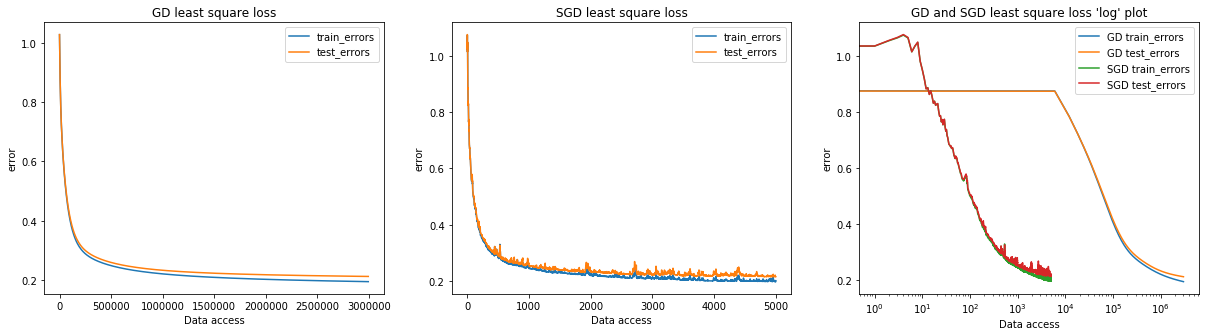

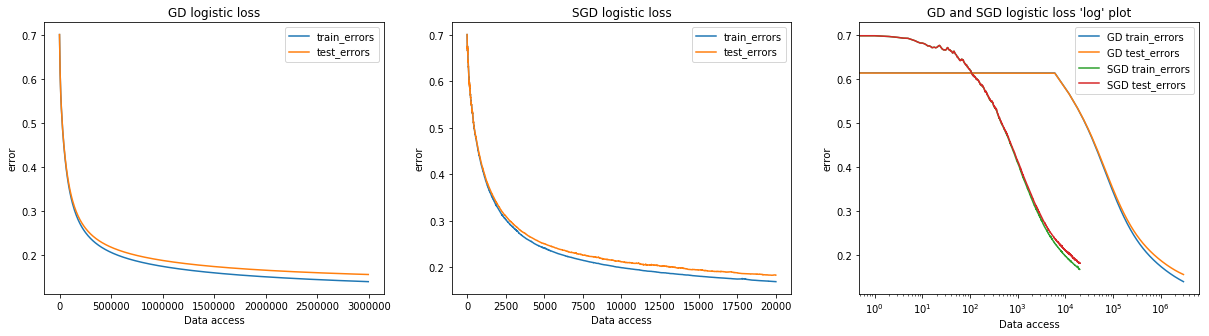

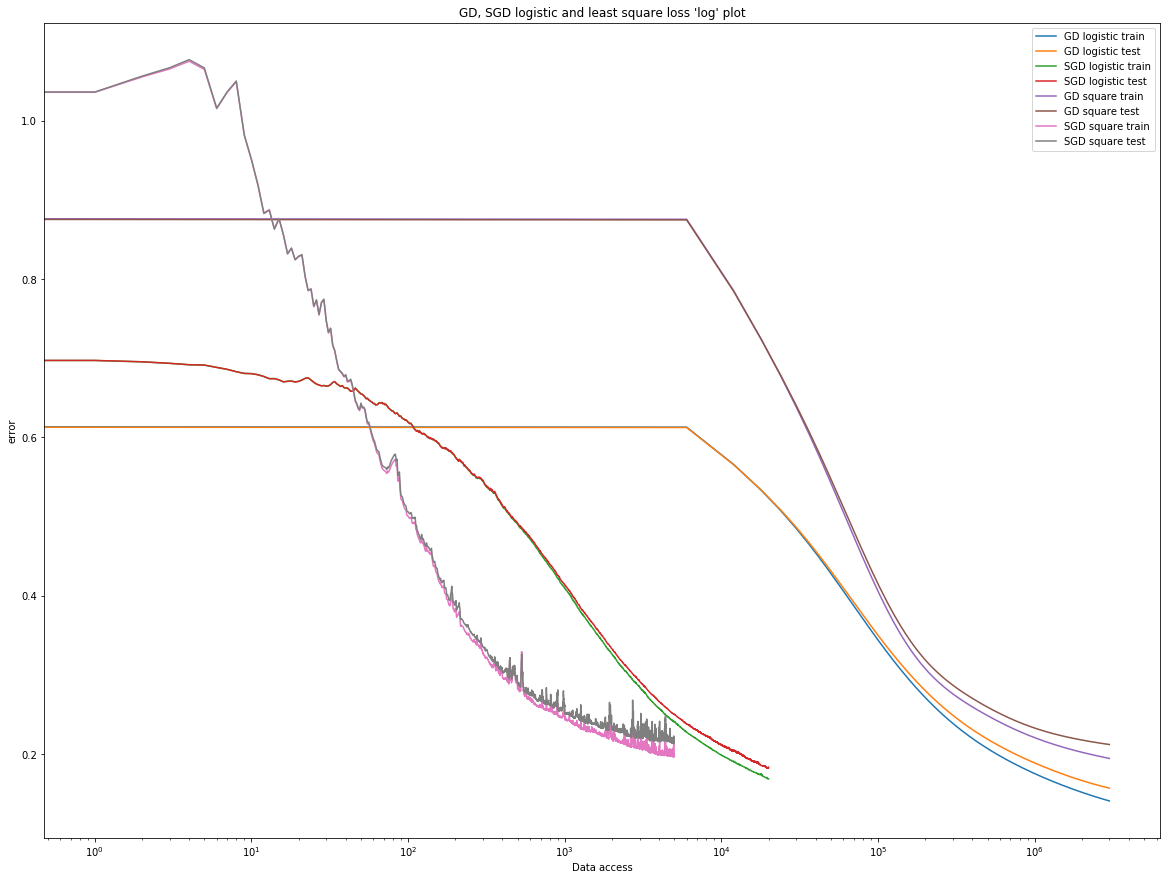

In [18]:
n = 6000
#plot GD/SGD Linear square 
plt.figure(figsize=(28, 5))
plt.subplot(1,4, 1)
plt.title("GD least square loss")
plt.plot(n*np.arange(len(strain_errors)), strain_errors, label="train_errors")
plt.plot(n*np.arange(len(strain_errors)), stest_errors, label="test_errors")
plt.xlabel("Data access")
plt.ylabel("error")
plt.legend()

plt.subplot(1,4, 2)
plt.title("SGD least square loss")
plt.plot(np.arange(len(strain_e)), strain_e, label="train_errors")
plt.plot(np.arange(len(strain_e)), stest_e, label="test_errors")
plt.xlabel("Data access")
plt.ylabel("error")
plt.legend()

plt.subplot(1, 4, 3)
plt.title("GD and SGD least square loss 'log' plot")
plt.semilogx(n*np.arange(len(strain_errors)), strain_errors, label="GD train_errors")
plt.semilogx(n*np.arange(len(strain_errors)), stest_errors, label="GD test_errors")
plt.semilogx(np.arange(len(strain_e)), strain_e, label="SGD train_errors")
plt.semilogx(np.arange(len(strain_e)), stest_e, label="SGD test_errors")
plt.xlabel("Data access")
plt.ylabel("error")
plt.legend()
plt.show()


#plot GD/SGD Logistic 
plt.figure(figsize=(28, 5))
plt.subplot(1,4, 1)
plt.title("GD logistic loss")
plt.plot(n*np.arange(len(ltrain_errors)), ltrain_errors, label="train_errors")
plt.plot(n*np.arange(len(ltrain_errors)), ltest_errors, label="test_errors")
plt.xlabel("Data access")
plt.ylabel("error")
plt.legend()

plt.subplot(1,4, 2)
plt.title("SGD logistic loss")
plt.plot(np.arange(len(ltrain_e)), ltrain_e, label="train_errors")
plt.plot(np.arange(len(ltrain_e)), ltest_e, label="test_errors")
plt.xlabel("Data access")
plt.ylabel("error")
plt.legend()

plt.subplot(1, 4, 3)
plt.title("GD and SGD logistic loss 'log' plot")
plt.semilogx(n*np.arange(len(ltrain_errors)), ltrain_errors, label="GD train_errors")
plt.semilogx(n*np.arange(len(ltrain_errors)), ltest_errors, label="GD test_errors")
plt.semilogx(np.arange(len(ltrain_e)), ltrain_e, label="SGD train_errors")
plt.semilogx(np.arange(len(ltrain_e)), ltest_e, label="SGD test_errors")
plt.xlabel("Data access")
plt.ylabel("error")
plt.legend()
plt.show()

# plot GD/SGD square and logistic 
plt.figure(figsize=(20, 15))
plt.title("GD, SGD logistic and least square loss 'log' plot")

plt.semilogx(n*np.arange(len(ltrain_errors)), ltrain_errors, label="GD logistic train")
plt.semilogx(n*np.arange(len(ltrain_errors)), ltest_errors, label="GD logistic test")
plt.semilogx(np.arange(len(ltrain_e)), ltrain_e, label="SGD logistic train")
plt.semilogx(np.arange(len(ltrain_e)), ltest_e, label="SGD logistic test")
plt.semilogx(n*np.arange(len(strain_errors)), strain_errors, label="GD square train")
plt.semilogx(n*np.arange(len(strain_errors)), stest_errors, label="GD square test")
plt.semilogx(np.arange(len(strain_e)), strain_e, label="SGD square train")
plt.semilogx(np.arange(len(strain_e)), stest_e, label="SGD square test")
plt.xlabel("Data access")
plt.ylabel("error")
plt.legend()
plt.show()

In [19]:
#using the function error
def rounds(n,theta, data, labels):
    e = error(data, theta, labels)
    acc = round(e[0], n)*100
    e_ = round(e[1], n)*100
    return acc, e_

title = ["Accuracy train(%)", "Error train(%)", "Accuracy test(%)", "Error test(%)"]
title2 = ["GD square loss ", "SGD square loss ", "GD logistic loss ", "SGD logistic loss "]
data = [[ rounds(2,stheta, train_data, train_labels)[0], rounds(2,stheta, train_data, train_labels)[1],rounds(2,stheta, test_data, test_labels)[0], rounds(4,stheta, test_data, test_labels)[1]],
        [ rounds(2,st,train_data, train_labels)[0], rounds(2,st,train_data, train_labels)[1],rounds(2,st,test_data, test_labels)[0], rounds(2,st,test_data, test_labels)[1]],
        [ rounds(2,ltheta,train_data, train_labels)[0], rounds(2,ltheta,train_data, train_labels)[1],rounds(2,ltheta,test_data, test_labels)[0], rounds(2,ltheta,test_data, test_labels)[1]],
        [ rounds(2,lt,train_data, train_labels)[0], rounds(2,lt,train_data, train_labels)[1],rounds(2,lt,test_data, test_labels)[0], rounds(2,lt,test_data, test_labels)[1]]]

format_row = "{:>19}" * (len(title) + 1)
print(format_row.format("Loss Function ",*title))
print("====="*(len(title[0])+2))
for team, row in zip(title2, data):
    print(format_row.format(team, *row))

     Loss Function   Accuracy train(%)     Error train(%)   Accuracy test(%)      Error test(%)
    GD square loss                96.0                4.0               95.0                4.8
   SGD square loss                96.0                4.0               95.0                5.0
  GD logistic loss                95.0                5.0               95.0                5.0
 SGD logistic loss                94.0                6.0               95.0                5.0


### Theta  and Average Theta Plots

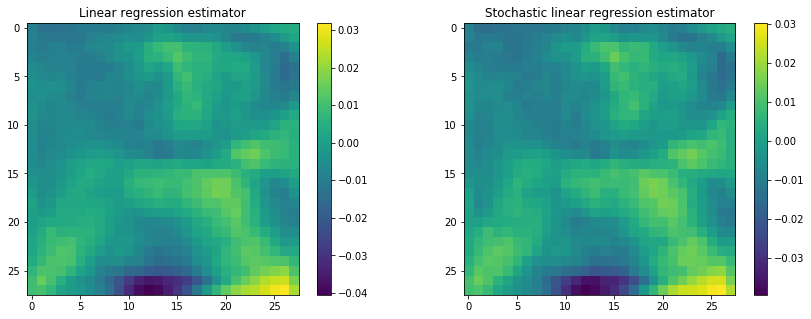

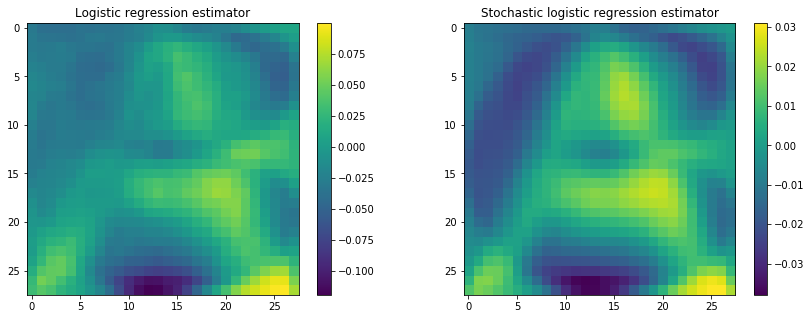

In [29]:
#plot estimator as image
plt.figure(figsize=(30, 5))
plt.subplot(1, 4, 1)
plt.imshow(stheta.reshape((28, 28)))
plt.title("Linear regression estimator")
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(st.reshape((28, 28)))
plt.title("Stochastic linear regression estimator")
plt.colorbar()
plt.show()

plt.figure(figsize=(30, 5))
plt.subplot(1, 4, 1)
plt.imshow(ltheta.reshape((28, 28)))
plt.colorbar()
plt.title("Logistic regression estimator")

plt.subplot(1, 4, 2)
plt.imshow(lt.reshape((28, 28)))
plt.title("Stochastic logistic regression estimator")
plt.colorbar()
plt.show()

Logistic Reg.: acc = 33.33%, err = 66.67%
Square   Reg.: acc = 86.8%, err = 13.200000000000001%


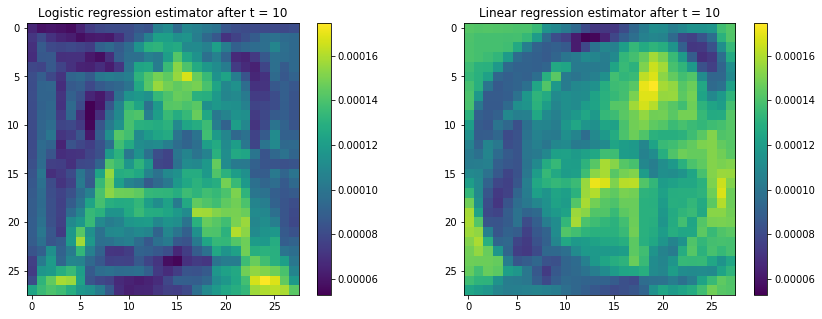

Logistic Reg.: acc = 70.93%, err = 29.07%
Square   Reg.: acc = 86.67%, err = 13.33%


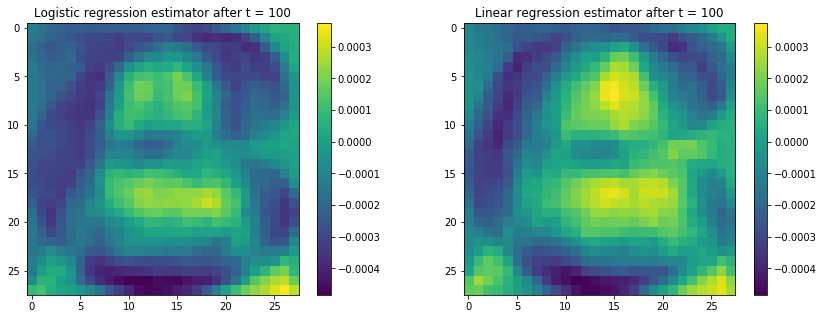

Logistic Reg.: acc = 81.07%, err = 18.93%
Square   Reg.: acc = 93.47%, err = 6.529999999999999%


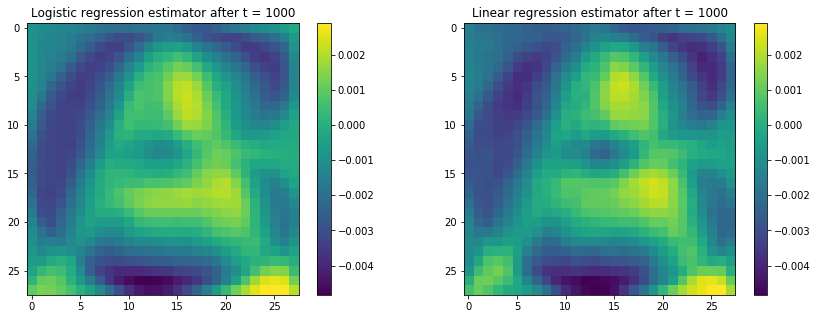

Logistic Reg.: acc = 93.2%, err = 6.800000000000001%
Square   Reg.: acc = 94.39999999999999%, err = 5.6000000000000005%


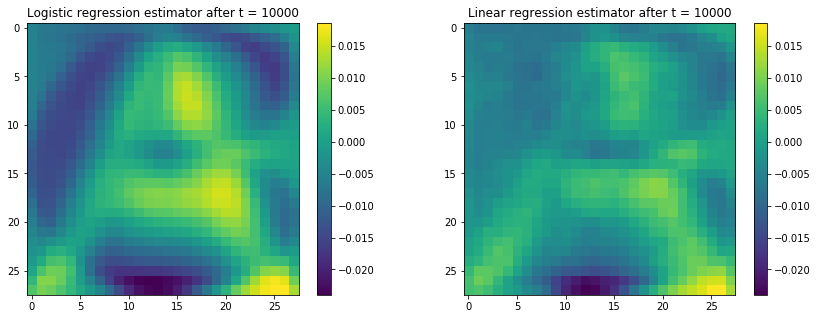

In [32]:
t = [10, 100, 1000, 10000]
for i in range(len(t)):
    itheta = np.ones(784)*1e-4
    lt, lt_avg, _, _ = stochastic_gradient_descent(train_data, train_labels, test_data, test_labels, 
                                                                itheta, 0, eta = 0.00005, max_iteration = t[i],case=0)
    itheta = np.ones(784)*1e-4
    st, st_avg, _, _ = stochastic_gradient_descent(train_data, train_labels, test_data, test_labels, 
                                                                itheta, 1, eta = 0.00005, max_iteration = t[i],case=0)
    
    print("Logistic Reg.: acc = {}%, err = {}%".format(rounds(4, lt_avg, test_data, test_labels)[0], rounds(4, lt_avg, test_data, test_labels)[1]))
    print("Square   Reg.: acc = {}%, err = {}%".format(rounds(4, st_avg,test_data, test_labels)[0], rounds(4, st_avg,  test_data, test_labels)[1]))

    plt.figure(figsize=(30,5))
    plt.subplot(1,4,1)
    plt.imshow(lt_avg.reshape((28,28)))
    plt.colorbar()
    plt.title("Logistic regression estimator after t = {}".format(t[i]))
    plt.subplot(1,4,2)
    plt.colorbar()
    plt.imshow(st_avg.reshape((28,28)))
    plt.title("Linear regression estimator after t = {}".format(t[i]))
    plt.show()

### KNN 

In [34]:
def euclid_dist(x,y): #x.shape =(6000,784) y.shape =(1,784)
    return (np.sum((x - y)**2, axis=1))**0.5

def get_closest_neighb(train_x, train_y, newx, k, f):
    distances = list(zip(f(train_x, newx), train_y))
    distances.sort(key=lambda x: x[0])
    neighb = distances[:k]
    s = np.sum(neighb, axis = 0)
    if s[1] > 0: return 1
    else: return -1

def knn (k, train_data, train_labels, test_data,f):
    v =[]
    for t in test_data:
        v.append(get_closest_neighb(train_data,train_labels, t, k, f))    
    return np.array(v)

def error(labels, predicted_labels):
    acc = np.sum(np.equal(labels,predicted_labels))/len(labels)
    return  acc , 1-acc

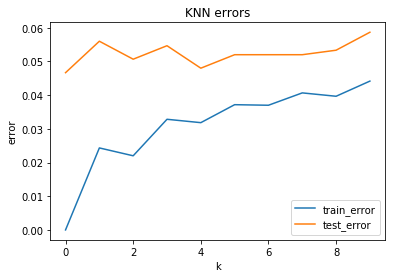

In [14]:
#plot knn with varying k
def run(train_data, train_labels, test_data, f, a, b):
    train_error = []
    test_error = []
    for k in range(a,b):
        #print(k)
        v = knn (k, train_data, train_labels, test_data, f)
        test_error.append(error(test_labels,v)[1])
        #print(test_error[-1])
        v2 = knn (k, train_data, train_labels, train_data, f)
        train_error.append(error(train_labels,v2)[1])
        #print(train_error[-1])
      
    plt.plot(train_error, label="train_error")
    plt.plot(test_error, label ="test_error")
    plt.xlabel("k")
    plt.ylabel("error")
    plt.legend()
    plt.title("KNN errors")

run(train_data, train_labels, test_data, euclid_dist , 1, 11)

Last error for k = 8 is err = 0.05066666666666666


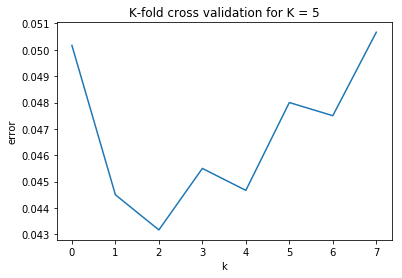

In [35]:
## K-fold cross validation with K = 5

def K_fold(n_splits, x, y, k):
    test_error = []
    for i in range(0, n_splits):
        d = int(len(x) / n_splits) 
        tests_x = np.array(x[i*d: (i+1)*d])
        tests_y = np.array(y[i*d: (i+1)*d])
        trains_x = np.concatenate([x[:i*d], x[(i+1)*d:]])
        trains_y = np.concatenate([y[:i*d], y[(i+1)*d:]])
        v = knn(k, trains_x, trains_y, tests_x, euclid_dist)
        test_error.append(error(tests_y,v)[1])
    return np.sum(test_error)/len(test_error)

def run_kfold(train_data, train_labels, n_splits, a,b):
    #data = np.array(list(zip(train_data, train_labels)))
    tab = np.arange(len(train_data))
    np.random.shuffle(tab)
    dx , dy = train_data[tab], train_labels[tab]
    err = []
    for k in range(a,b):
        err.append(K_fold(n_splits, dx,dy, k))
    plt.plot(err)
    plt.xlabel("k")
    plt.ylabel("error")
    plt.title("K-fold cross validation for K = {}".format(n_splits))
    print("Last error for k = {} is err = {}".format(b-1, err[-1]))

run_kfold(train_data, train_labels, 5, 1,9)